In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt
from skimage import transform as trans
from sklearn.preprocessing import normalize

In [2]:
def aligned_face(img, landmark):
    src = np.array([
        [30.2946, 51.6963],
        [65.5318, 51.5014],
        [48.0252, 71.7366],
        [33.5493, 92.3655],
        [62.7299, 92.2041] ], dtype=np.float32)
    dst = np.array(landmark, dtype=np.float32).reshape(5, 2)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src)
    M = tform.params[0:2,:]
    aligned = cv2.warpAffine(img, M, (112, 112), borderValue = 0)
    return aligned

In [3]:
def compare_faces(embedding, threshold):
    # read db
    with open('db.pkl', 'rb') as file:
        db = pickle.load(file)
    db_embeddings = db['embeddings']
    db_names = db['names']

    distances = np.zeros((len(db_embeddings)))
    for i, db_embedding in enumerate(db_embeddings):
        distance = round(np.linalg.norm(db_embedding-embedding), 2)
        distances[i] = distance
    idx_min = np.argmin(distances)
    distance, name = distances[idx_min], db_names[idx_min]
    if distance < threshold:
        return name, distance
    else:
        return False, distance

In [4]:
def get_embeddings(extractor, img, landmarks):    
    embeddings = np.zeros((len(landmarks), 512))
    for idx, landmark in enumerate(landmarks):
        aligned = aligned_face(img, landmark)
        aligned = (aligned/255-0.5)/0.5
        aligned = aligned.transpose((2, 0, 1))
        inputs = np.expand_dims(aligned, axis=0)
        inname = [input.name for input in extractor.get_inputs()][0]
        outname = [output.name for output in extractor.get_outputs()]
        embedding = extractor.run(outname, {inname:inputs})[0]
        embeddings[idx] = normalize(embedding).flatten()
    return embeddings

In [5]:
# load RetinaFace detector
from retinaface import RetinaFace
# init with normal accuracy option
detector = RetinaFace(quality="normal")
# load facenet model
onnx_path = "model/model.onnx"
extractor = ort.InferenceSession(onnx_path)

model[normal quality] init ..
model success !


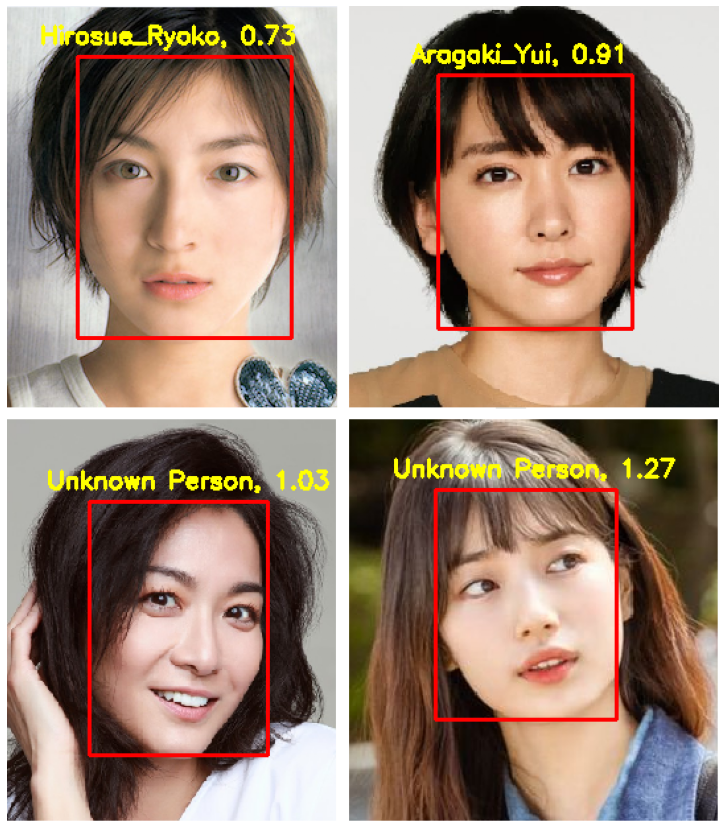

In [6]:
img_path = 'test.png'
imgBGR = cv2.imread(img_path, cv2.IMREAD_COLOR).astype('float32')
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
# detect faces in the image

detections = detector.predict(imgRGB)
facePositions = [(detection.pop('x1'), detection.pop('y1'), detection.pop('x2'), detection.pop('y2')) for detection in detections]
landmarks = [list(detection.values()) for detection in detections]
embeddings = get_embeddings(extractor, imgRGB, landmarks)

font = cv2.FONT_HERSHEY_SIMPLEX
for facePosition, embedding in zip(facePositions, embeddings):
    name = 'Unknown Person' 
    matches = compare_faces(embedding, threshold=1)
    distance = matches[1]
    if False not in matches:
        name = matches[0]
    x1, y1, x2, y2 = facePosition
    cv2.rectangle(imgRGB, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(imgRGB, name+', '+str(distance), (x1-int(len(name)**2/6), y1-10), font, 0.6, (255, 255, 0), 2)
plt.figure(figsize=(15, 15))
plt.imshow(imgRGB/255)
_ = plt.axis('off')

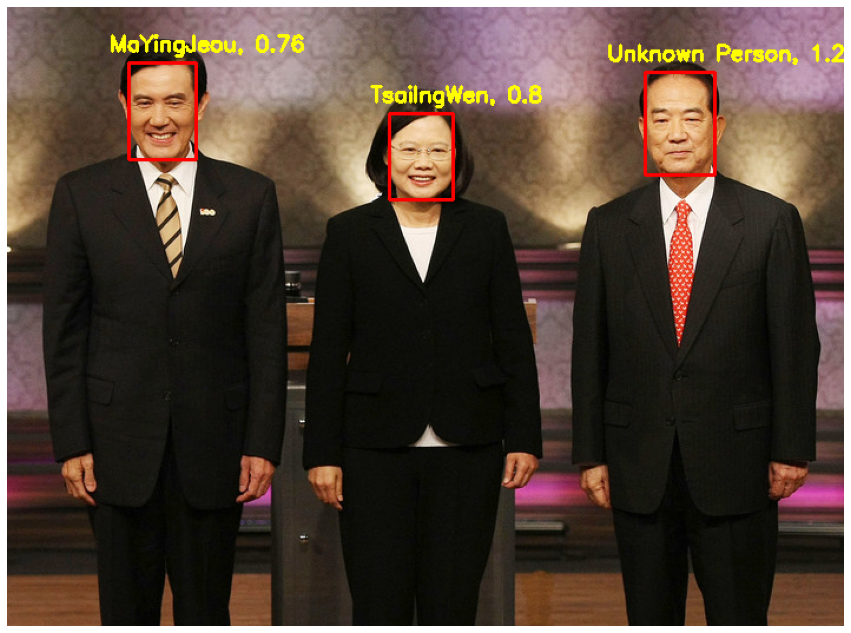

In [7]:
img_path = 'test1.png'
imgBGR = cv2.imread(img_path, cv2.IMREAD_COLOR).astype('float32')
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
# detect faces in the image

detections = detector.predict(imgRGB)
facePositions = [(detection.pop('x1'), detection.pop('y1'), detection.pop('x2'), detection.pop('y2')) for detection in detections]
landmarks = [list(detection.values()) for detection in detections]
embeddings = get_embeddings(extractor, imgRGB, landmarks)

font = cv2.FONT_HERSHEY_SIMPLEX
for facePosition, embedding in zip(facePositions, embeddings):
    name = 'Unknown Person' 
    matches = compare_faces(embedding, threshold=1)
    distance = matches[1]
    if False not in matches:
        name = matches[0]
    x1, y1, x2, y2 = facePosition
    cv2.rectangle(imgRGB, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(imgRGB, name+', '+str(distance), (x1-int(len(name)**2/6), y1-10), font, 0.6, (255, 255, 0), 2)
plt.figure(figsize=(15, 15))
plt.imshow(imgRGB/255)
_ = plt.axis('off')